In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
import os
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import scikitplot as skplt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aom2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aom2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
for f in os.listdir("content"):
    print(f)

BinMLResultsada_tfidf_binmat.png
BinMLResultsgb_tfidf_binmat.png
BinMLResultsknn_tfidf_binmat.png
BinMLResultslr_tfidf_binmat.png
BinMLResultsnb_tfidf_binmat.png
BinMLResultsrf_tfidf_binmat.png
BinMLResultssvm_countvec_binmat.png
BinMLResultssvm_tfidf_binmat.png
final_testset.xlsx
final_trainset.xlsx


In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aom2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:

df_bin = pd.read_excel("content/final_trainset.xlsx")
df_bin['ABSTRACT'] = df_bin['ABSTRACT'].apply(str.lower)

# remove stop words
stop_words = set(stopwords.words('english'))
df_bin['ABSTRACT'] = df_bin['ABSTRACT'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Stemming
stemmer = PorterStemmer()
df_bin['ABSTRACT'] = df_bin['ABSTRACT'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))

# Lemmatization
lemmatizer = WordNetLemmatizer()
df_bin['ABSTRACT'] = df_bin['ABSTRACT'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

# Load the test dataset
df_test = pd.read_excel("content/final_testset.xlsx")
df_test['ABSTRACT'] = df_test['ABSTRACT'].apply(str.lower)
# Apply the same preprocessing to the test data
df_test['ABSTRACT'] = df_test['ABSTRACT'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df_test['ABSTRACT'] = df_test['ABSTRACT'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
df_test['ABSTRACT'] = df_test['ABSTRACT'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))


In [5]:
df_test['ABSTRACT']

0      descript lambert-eaton syndrom base symptomat ...
1      final week 6-month epidem ebola hemorrhag feve...
2      neurofibromatosi type 1 ( nf1 ) genet diseas c...
3      primari biliari cirrhosi chronic cholestat liv...
4      rise tide non-alcohol fatti liver diseas ( naf...
                             ...                        
411    immun thrombocytopen purpura ( itp ) child com...
412    6-thioguanin ( 6-tg ) use altern thiopurin inf...
413    littl known etiolog associ clinic featur extra...
414    evalu clinic characterist patient hematolog di...
415    disease-specif unifi multipl system atrophi ra...
Name: ABSTRACT, Length: 416, dtype: object

In [6]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import scikitplot as skplt

def bin_model(model_type, vectortype, C=1,select_features=8150):
    # Vectorization
    if vectortype == "tfidf":
        vectorizer = TfidfVectorizer()
    elif vectortype == "countvec":
        vectorizer = CountVectorizer()
        
    X_train = vectorizer.fit_transform(df_bin['ABSTRACT'])
    y_train = df_bin['binary2_label']
    feature_names = vectorizer.get_feature_names_out()
    
    # Feature Selection
    selector = SelectKBest(score_func=chi2, k=select_features)
    X_train_sel = selector.fit_transform(X_train, y_train)
    
    # Get the mask of the selected features
    selected_mask = selector.get_support()
    selected_features = feature_names[selected_mask]

    # Model Training
    if model_type == 'nb':
        model = MultinomialNB()
    elif model_type == 'lr':
        model = LogisticRegression(max_iter=1000)
    elif model_type == 'svm':
        model = LinearSVC(C=C)
    elif model_type == 'knn':
        model = KNeighborsClassifier(n_neighbors=7)
    elif model_type == 'rf':
        model = RandomForestClassifier()
    elif model_type == 'ada':
        model = AdaBoostClassifier(n_estimators=50)
    elif model_type == 'gb':
        model = GradientBoostingClassifier(n_estimators=50)

    model.fit(X_train_sel, y_train)
    print('Training Accuracy:', model.score(X_train_sel, y_train))

    # Applying the same transformation to the test data
    X_test = vectorizer.transform(df_test['ABSTRACT'])
    X_test_sel = selector.transform(X_test)
    y_test = df_test['binary2_label']
    y_pred = model.predict(X_test_sel)

    # Evaluation
    print('Test Accuracy:', accuracy_score(y_test, y_pred))
    print('F1 score:', f1_score(y_test, y_pred, average="macro"))
    print('Precision:', precision_score(y_test, y_pred, average="macro"))
    print('Recall:', recall_score(y_test, y_pred, average="macro"))

    # Confusion Matrix Plot
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_confusion_matrix(y_test, y_pred,
                                        title="Binary Confusion Matrix",
                                        ax=ax1)
    plt.savefig('content/BinMLResults' + model_type + '_' + vectortype + '_binmat.png')

    return X_train, y_train, feature_names,X_train_sel, y_pred,selected_features


In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

C:\Users\aom2\AppData\Local\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Accuracy: 0.9014137843978793
Test Accuracy: 0.78125
F1 score: 0.7721809986339045
Precision: 0.7801282051282051
Recall: 0.7685861522823441


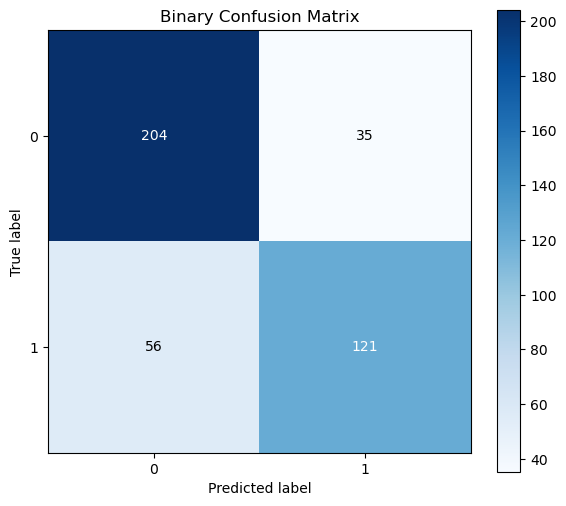

In [8]:
 X_train, y_train, feature_names,X_train_sel, y_pred,selected_features=bin_model('svm', 'tfidf',C=0.5,select_features=8000)

C:\Users\aom2\AppData\Local\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Accuracy: 0.8275687957586468
Test Accuracy: 0.7620192307692307
F1 score: 0.7483363581367211
Precision: 0.7650611699393441
Recall: 0.7437888565822754


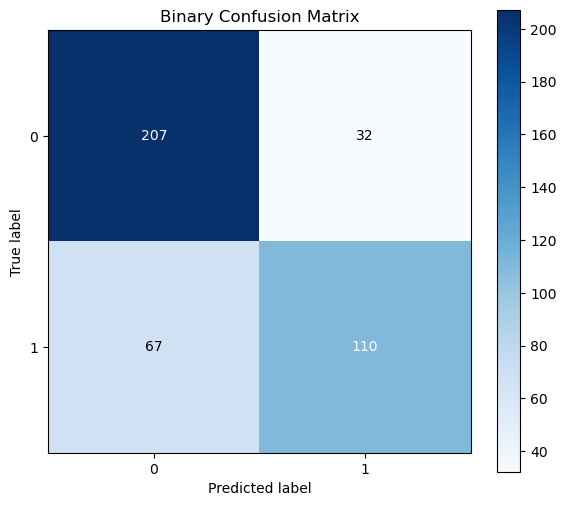

In [9]:
X_train, y_train, feature_names,X_train_sel, y_pred,selected_features=bin_model('svm', 'tfidf',C=0.1,select_features=8000)

C:\Users\aom2\AppData\Local\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Accuracy: 0.9283009341075485
Test Accuracy: 0.7836538461538461
F1 score: 0.7749080152947118
Precision: 0.7823574256695276
Recall: 0.7714110110394061


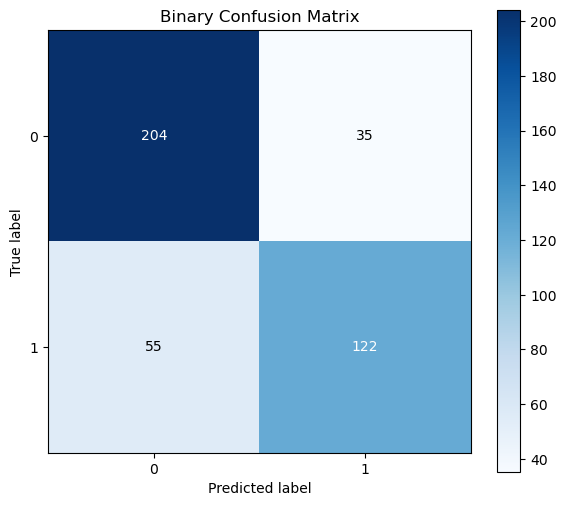

In [10]:
 X_train, y_train, feature_names,X_train_sel, y_pred,selected_features=bin_model('svm', 'tfidf',C=1,select_features=8000)

In [12]:
def bin_model(model_type, vectortype,C=1):
    # Ensure df_bin and df_test are defined outside this function and accessible here
    global df_bin, df_test

    if vectortype == "tfidf":
        vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    elif vectortype == "countvec":
        vectorizer = CountVectorizer(ngram_range=(1, 2))
    
    X_train = vectorizer.fit_transform(df_bin['ABSTRACT'])
    y_train = df_bin['binary2_label']

    # Define the model based on model_type
    if model_type == 'nb':
        model = MultinomialNB()
    elif model_type == 'lr':
        model = LogisticRegression(C=0.1, max_iter=1000)
    elif model_type == 'svm':
        model = LinearSVC(C=C)
    elif model_type == 'knn':
        model = KNeighborsClassifier(n_neighbors=7)
    elif model_type == 'rf':
        model = RandomForestClassifier(n_estimators=100, max_depth=10)
    elif model_type == 'ada':
        model = AdaBoostClassifier(n_estimators=50)
    elif model_type == 'gb':
        model = GradientBoostingClassifier(n_estimators=100, validation_fraction=0.1, n_iter_no_change=10, tol=0.01)
    
    # Fit the model
    model.fit(X_train, y_train)
    print('Training Accuracy:', model.score(X_train, y_train))

    # Transform the test set using the same vectorizer and predict
    X_test = vectorizer.transform(df_test['ABSTRACT'])
    y_test = df_test['binary2_label']
    y_pred = model.predict(X_test)

    print('Test Accuracy:', accuracy_score(y_test, y_pred))
    print('F1 score:', f1_score(y_test, y_pred, average="macro"))
    print('Precision:', precision_score(y_test, y_pred, average="macro"))
    print('Recall:', recall_score(y_test, y_pred, average="macro"))

    # Plot the confusion matrix
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, title="Binary Confusion Matrix", ax=ax1)
    plt.savefig('content/BinMLResults' + model_type + '_' + vectortype + '_binmat.png')
    # return y_test, y_pred


C:\Users\aom2\AppData\Local\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Accuracy: 0.9950770007573845
Test Accuracy: 0.7860576923076923
F1 score: 0.7796387227330893
Precision: 0.7821620583717357
Recall: 0.777899912535754


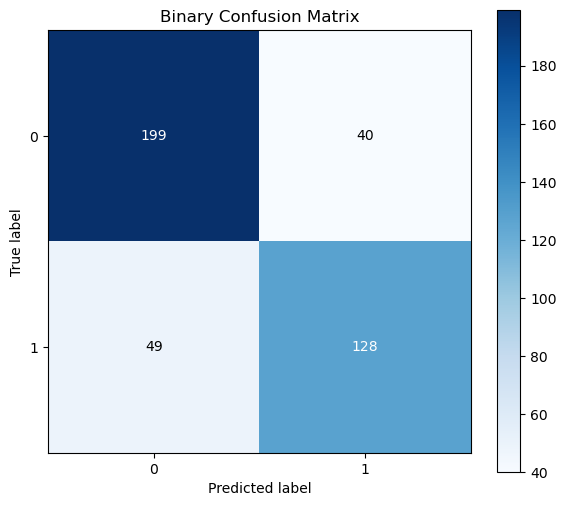

In [13]:
bin_model('svm', 'tfidf',C=0.5)

C:\Users\aom2\AppData\Local\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Accuracy: 0.9998737692501893
Test Accuracy: 0.7884615384615384
F1 score: 0.7811573409851746
Precision: 0.7857125536506705
Recall: 0.7785263456492447


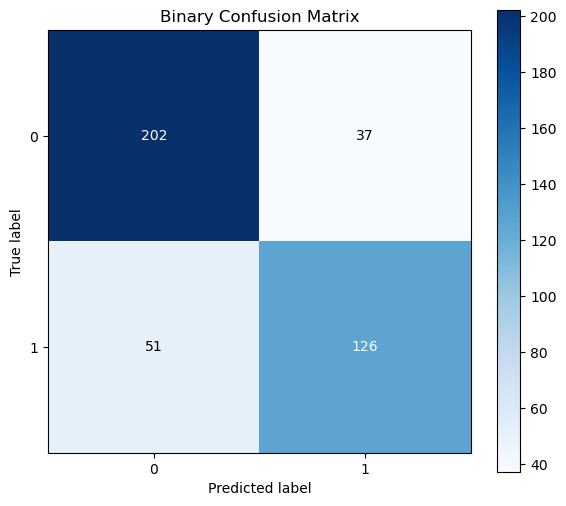

In [14]:
bin_model('svm', 'tfidf',C=1.2)